<a href="https://colab.research.google.com/github/solobala/TSML13/blob/main/TSML13_DZ4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание
 - Выберите ряд из первого задания.
 - Постройте его модель GARCH.
Оформите отчёт в Jupyter-ноутбук.
 - **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

# Импорт библиотек и функции

In [ ]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 8.6 MB/s eta 0:00:00


In [ ]:
!pip install statsmodels

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_predict
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
from scipy.stats import boxcox
from pathlib import Path
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

In [ ]:
from arch import arch_model
from arch.univariate import ARCH, GARCH
from arch.univariate import EGARCH, FIGARCH, APARCH, HARCH
from arch.univariate import ConstantMean, ZeroMean, HARX, ARX, LS
from arch.univariate import Normal, StudentsT, SkewStudent, GeneralizedError

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [ ]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

In [ ]:
def _get_best_model(TS, vols):
    lags=[5,8,11, 12]
    best_aic = np.inf
    best_order = None
    best_mdl = None
    best_mean = None
    best_dist = None
    best_vol = None
    best_lag = None
    # Модель строится  с помощью конструктора arch_model из трех разных составляющих -
    # волатильности ( vol), распределения ( distributions) и среднего ( Mean)
    means = ['Constant', 'Zero', 'LS', 'ARX', 'HARX']
    distributions=['normal', 'studentst', 'skewstudent', 'generalized error']

    for dist in tqdm(distributions):
      for vol in vols:
        for mean in means:
           for lag in lags:
              for p_ in [0,1]:
                for o_ in [0,1]:
                  for q_ in [0,1]:
                    if (p_>0) or  (o_> 0):
                        try:
                            tmp_model = arch_model(TS, mean=mean, lags=lag, vol=vol, p=p_,  o=o_, q=q_, dist=dist, hold_back=lag)
                            tmp_mdl = tmp_model.fit(update_freq=5, disp='off', show_warning=False)
                            tmp_aic = tmp_mdl.aic
                            if tmp_aic < best_aic:
                                best_aic = tmp_aic
                                best_order = p_, o_, q_
                                best_mdl = tmp_mdl
                                best_mean = mean
                                best_lag = lag
                                best_vol = vol
                                best_dist = dist
                        except (Exception or ConvergenceWarning):
                          continue
    print(best_order, best_mean, best_vol, best_lag,best_dist)
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mean, best_vol, best_lag, best_dist, best_mdl


In [ ]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data[data.columns[1]].shift(i)

    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop([data.columns[0]], axis=1)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop([data.columns[1]], axis=1)
    y_train = data.loc[:test_index][data.columns[1]]
    X_test = data.loc[test_index:].drop([data.columns[1]], axis=1)
    y_test = data.loc[test_index:][data.columns[1]]

    return X_train, X_test, y_train, y_test

# Загрузка данных

In [ ]:
drive.mount('/content/drive')
ROOT = '/content/drive/MyDrive/TSML13_DZ1'
SERIES = Path(ROOT, 'Series')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
arch_series = pd.read_csv("/content/drive/MyDrive/TSML13_DZ1/Series/monthly-boston-armed-robberies-j.csv")['Count']

# ARCH/GARCH

In [ ]:
ts = arch_series.copy()

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


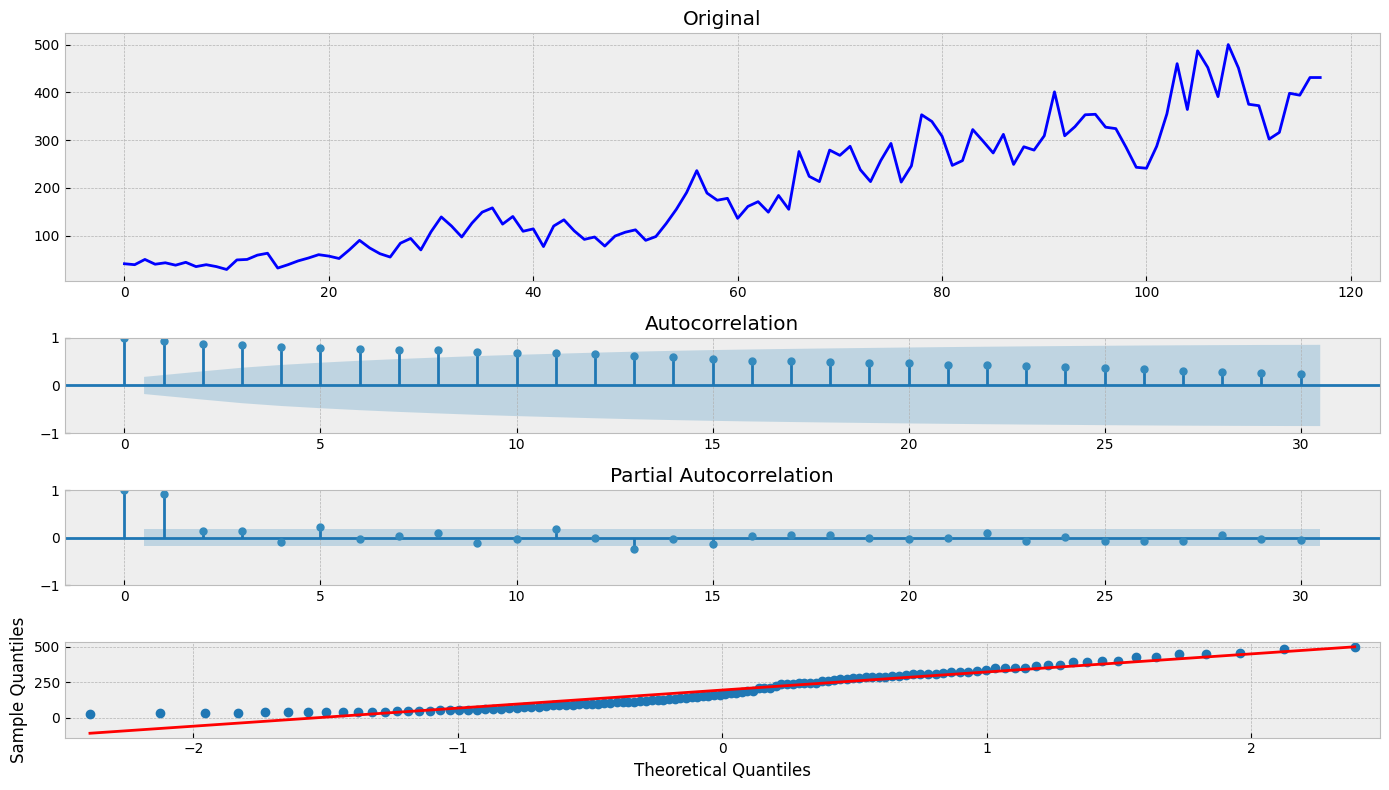

In [ ]:
tsplot(ts, lags=30)

Нормирование дисперсии, однократное дифференцирование

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


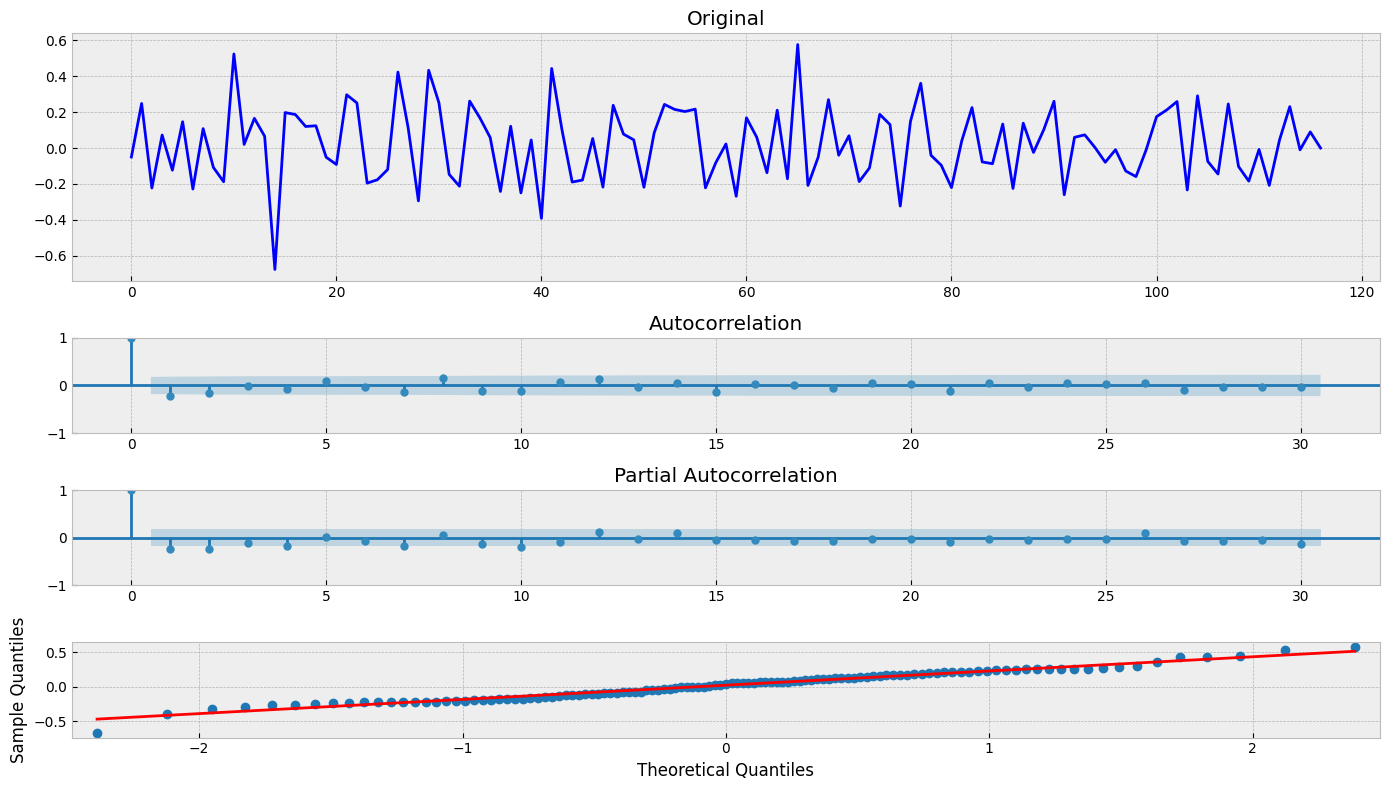

In [ ]:
ts = np.array(ts)
ts = boxcox(ts, 0)
ts = ts[1:] - ts[:-1]

tsplot(ts, lags=30)

Подбор модели с волатильностью ARCH/GARCH из условия минимизации AIC

In [ ]:
vols = [ 'GARCH', 'ARCH']

In [ ]:
best_aic, best_order, best_mean, best_vol, best_lag, best_dist, best_mdl = _get_best_model(ts, vols)

  0%|          | 0/4 [00:00<?, ?it/s]

(0, 1, 1) ARX GARCH 11 normal
aic: -42.97337 | order: (0, 1, 1)


In [ ]:
print(best_mdl.summary())

                         AR - GJR-GARCH Model Results                         
Dep. Variable:                      y   R-squared:                       0.231
Mean Model:                        AR   Adj. R-squared:                  0.141
Vol Model:                  GJR-GARCH   Log-Likelihood:                36.4867
Distribution:                  Normal   AIC:                          -42.9734
Method:            Maximum Likelihood   BIC:                          -3.02179
                                        No. Observations:                  106
Date:                Fri, Nov 24 2023   Df Residuals:                       94
Time:                        07:57:18   Df Model:                           12
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          0.0688  3.338e-02      2.062  3.919e-02  [3.41

In [ ]:
# Конструируем модель с подобранными параметрами
am = ARX(ts, lags=11, constant=True)
am.volatility = GARCH(0,1,1)
np.random.seed = 42
am.distribution = Normal()
res = am.fit()

Iteration:      1,   Func. Count:     17,   Neg. LLF: 11429129382.90095
Iteration:      2,   Func. Count:     37,   Neg. LLF: 3990976964.750201
Iteration:      3,   Func. Count:     55,   Neg. LLF: 597.3118354099165
Iteration:      4,   Func. Count:     73,   Neg. LLF: 104.35000378288544
Iteration:      5,   Func. Count:     91,   Neg. LLF: 171379057.2190757
Iteration:      6,   Func. Count:    111,   Neg. LLF: 10.82577485571629
Iteration:      7,   Func. Count:    129,   Neg. LLF: -10.653990793526154
Iteration:      8,   Func. Count:    147,   Neg. LLF: -2.745101461901415
Iteration:      9,   Func. Count:    165,   Neg. LLF: -25.57942386810721
Iteration:     10,   Func. Count:    182,   Neg. LLF: 38.68555745493561
Iteration:     11,   Func. Count:    200,   Neg. LLF: 34.48754619547435
Iteration:     12,   Func. Count:    218,   Neg. LLF: -22.522620916927092
Iteration:     13,   Func. Count:    235,   Neg. LLF: -32.060925832406426
Iteration:     14,   Func. Count:    252,   Neg. LLF: 5

In [ ]:
print(res.summary())

                         AR - GJR-GARCH Model Results                         
Dep. Variable:                      y   R-squared:                       0.231
Mean Model:                        AR   Adj. R-squared:                  0.141
Vol Model:                  GJR-GARCH   Log-Likelihood:                36.4867
Distribution:                  Normal   AIC:                          -42.9734
Method:            Maximum Likelihood   BIC:                          -3.02179
                                        No. Observations:                  106
Date:                Fri, Nov 24 2023   Df Residuals:                       94
Time:                        07:59:16   Df Model:                           12
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          0.0688  3.338e-02      2.062  3.919e-02  [3.41

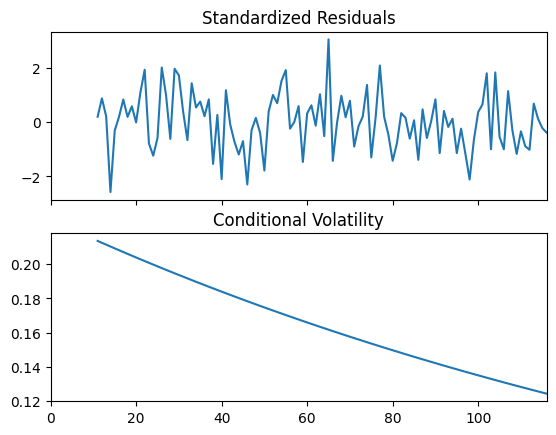

In [ ]:
fig = res.plot() # Это результаты GARCH

Results of Dickey-Fuller Test:
Test Statistic                -9.793192e+00
p-value                        6.273681e-17
#Lags Used                     0.000000e+00
Number of Observations Used    1.050000e+02
Critical Value (1%)           -3.494220e+00
Critical Value (5%)           -2.889485e+00
Critical Value (10%)          -2.581676e+00
dtype: float64


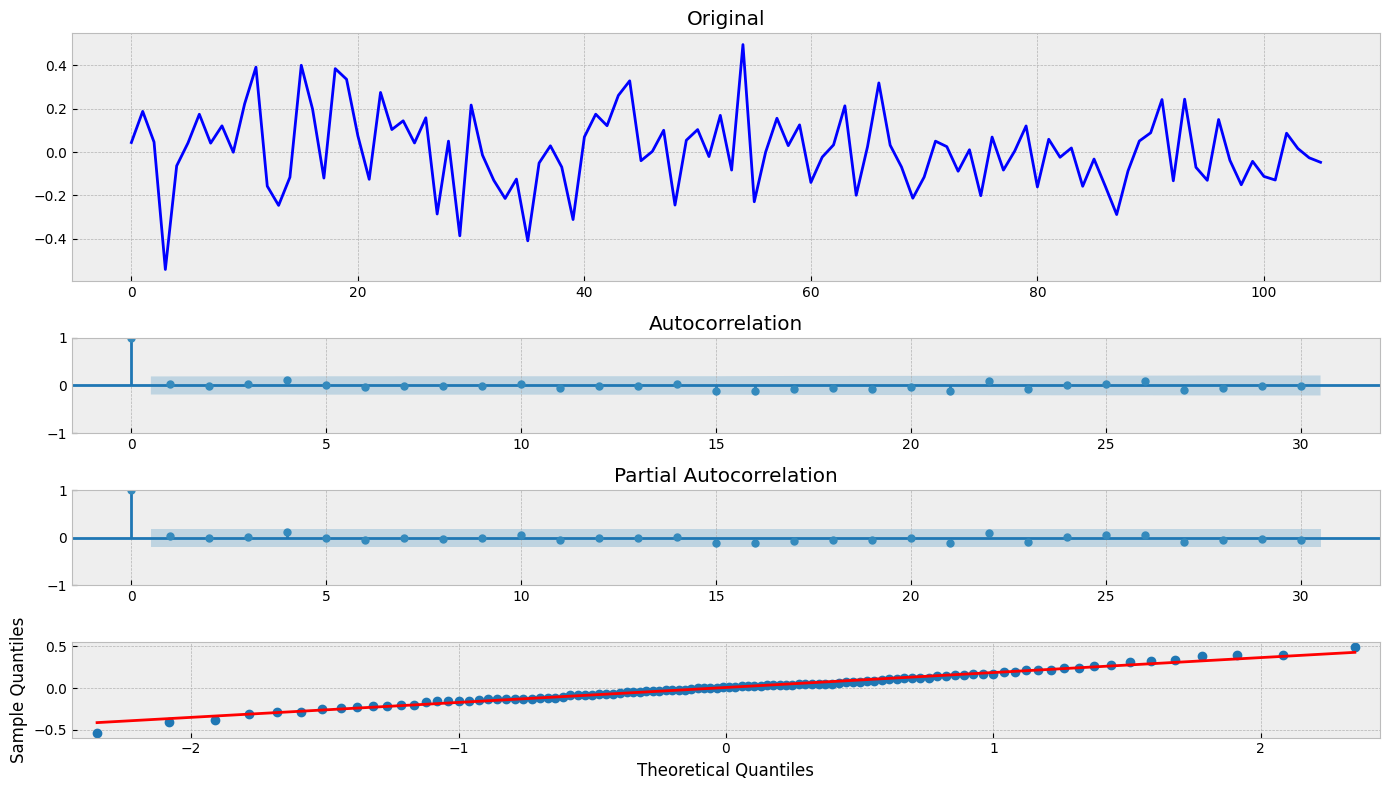

In [ ]:
tsplot(res.resid[11:], lags=30)

# EGARCH/FIGARCH/APARCH/HARCH

In [ ]:
vols = ['EGARCH', 'FIGARCH', 'APARCH', 'HARCH']
best_aic, best_order, best_mean, best_vol, best_lag, best_dist, best_mdl = _get_best_model(ts, vols)

  0%|          | 0/4 [00:00<?, ?it/s]

(1, 1, 0) HARX EGARCH 11 skewstudent
aic: -74.69488 | order: (1, 1, 0)


In [ ]:
print(best_mdl.summary())

                                HAR - EARCH Model Results                                
Dep. Variable:                                 y   R-squared:                       0.081
Mean Model:                                  HAR   Adj. R-squared:                 -0.027
Vol Model:                                 EARCH   Log-Likelihood:                54.3474
Distribution:      Standardized Skew Student's t   AIC:                          -74.6949
Method:                       Maximum Likelihood   BIC:                          -29.4164
                                                   No. Observations:                  106
Date:                           Fri, Nov 24 2023   Df Residuals:                       94
Time:                                   08:13:51   Df Model:                           12
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
--------------------------------

Похоже, модель EGARCH не сработала, за заданное число итераций сходимость не достигнута. Проверим это, сконструировав модель с тем параметрами, что были найдены, и увеличив число итераций

In [ ]:
# Конструируем модель с подобранными параметрами
am = HARX(ts, lags=11, constant=True)
am.volatility = EGARCH(1,1,0)
am.distribution = SkewStudent()
res = am.fit(options={'maxiter': 400})

Iteration:      1,   Func. Count:     19,   Neg. LLF: 6813.554737270893
Iteration:      2,   Func. Count:     39,   Neg. LLF: 5047.337369286186
Iteration:      3,   Func. Count:     59,   Neg. LLF: 39068.741502459845
Iteration:      4,   Func. Count:     78,   Neg. LLF: 19309.794488793974
Iteration:      5,   Func. Count:     98,   Neg. LLF: 10177.899823561347
Iteration:      6,   Func. Count:    118,   Neg. LLF: 48594.04483852386
Iteration:      7,   Func. Count:    137,   Neg. LLF: 15840.510247390275
Iteration:      8,   Func. Count:    157,   Neg. LLF: 271.6354306699589
Iteration:      9,   Func. Count:    176,   Neg. LLF: 43802.03853380204
Iteration:     10,   Func. Count:    196,   Neg. LLF: 15355.42813614464
Iteration:     11,   Func. Count:    216,   Neg. LLF: -16.764319507290438
Iteration:     12,   Func. Count:    235,   Neg. LLF: 57.59548192960194
Iteration:     13,   Func. Count:    254,   Neg. LLF: -32.359759713857365
Iteration:     14,   Func. Count:    273,   Neg. LLF: -3

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Итак, выбираем модель из 1 варианта модель

# Попробуйте спрогнозировать график классическим ML

In [ ]:
ts = pd.read_csv("/content/drive/MyDrive/TSML13_DZ1/Series/monthly-boston-armed-robberies-j.csv")

In [ ]:
X_train, X_test, y_train, y_test = prepareData(ts, lag_start=1, lag_end=11, test_size=0.3)


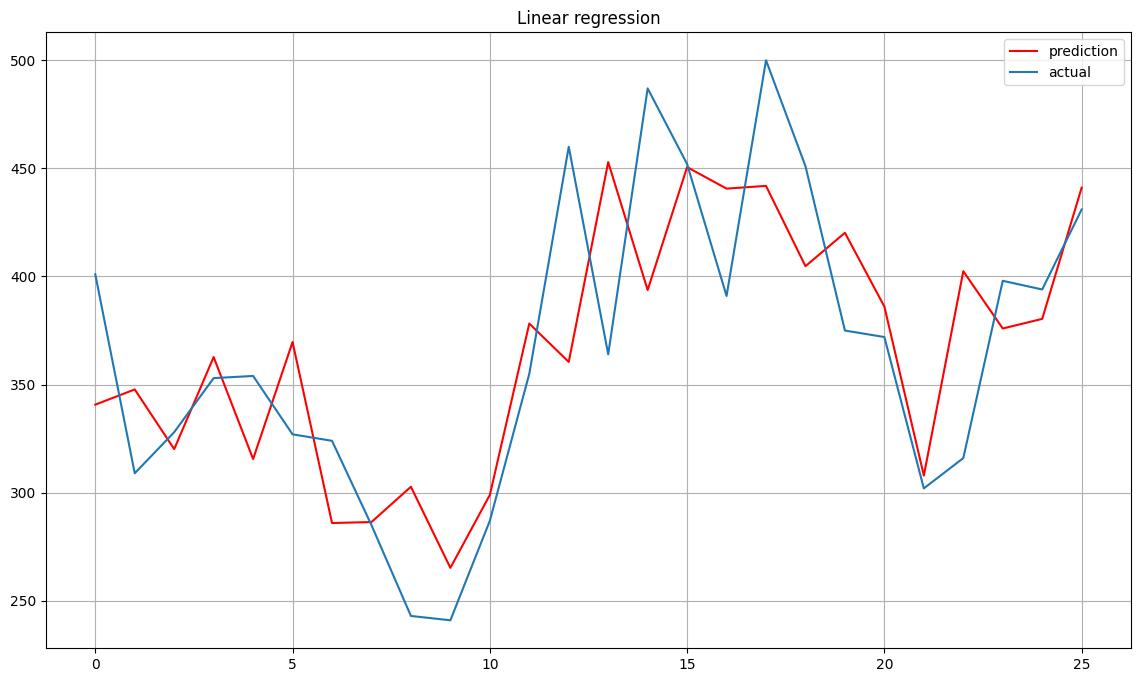

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);